##### 190713X - L.H.N.WIJEWARDENA
Exercise 08

Question 1,2

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
f=open(r'templeSparseRing\templeSR_par.txt','r')
assert f is not None
n= int(f.readline())

#reading the information of the 2nd image 
l=f.readline().split()
im1_fn=l[0]

k1=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1=np.array([float(i) for i in l[19:22]]).reshape((3,1))

#reading the information of the 2nd image 

l=f.readline().split()
im2_fn=l[0]

k2=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2=np.array([float(i) for i in l[19:22]]).reshape((3,1))

#read the two images and show
im1= cv.imread(r'templeSparseRing/' + im1_fn,cv.IMREAD_COLOR)
im2= cv.imread(r'templeSparseRing/' + im2_fn,cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None

#compute p1 and p2
#P=k*[R|t]
P1=k1@np.hstack((R1,t1)) 
P2=k2@np.hstack((R2,t2))

print(P1)
print(P2)

[[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
[[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


In [5]:
from scipy.linalg import null_space

def skew(x):

    x=x.ravel()
    return np.array([[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])

C=null_space(P1)
C=C*np.sign(C[0,0])
e2=P2@C
e2x=skew(e2)
F=e2x@P2@np.linalg.pinv(P1)
print(F)

[[-2.87071497e-04 -3.96261289e-02  2.94221686e+02]
 [-3.55039713e-02  1.65329260e-04  1.78860854e+01]
 [-2.76702814e+02  2.12942175e+01 -9.06669374e+03]]


Question 3

Text(0.5, 1.0, 'Epipolar Line')

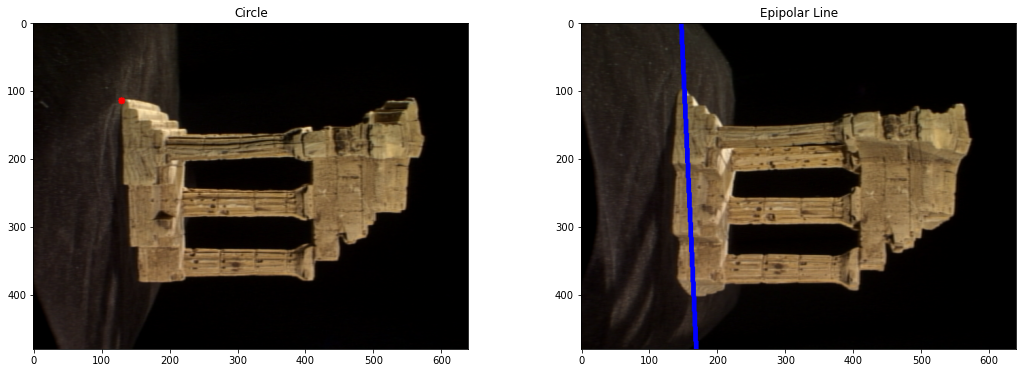

In [22]:
x=np.array([130,115,1])
cv.circle(im1,(x[0],x[1]),5,(0,0,255),-1)

l2=F @ x.T
p1=np.array([0,(l2[0]*0+l2[2])/l2[1]]).astype(int)
p2=np.array([500,(l2[0]*500+l2[2])/l2[1]]).astype(int)
cv.line(im2,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)
cv.namedWindow('im')
cv.imshow('im',im1)
cv.waitKey(0)
cv.imshow('im',im2)
cv.waitKey(0)
cv.destroyAllWindows()

fig,ax=plt.subplots(1,2,figsize=(18,6))
ax[0].imshow(cv.cvtColor(im1,cv.COLOR_BGR2RGB))
ax[0].set_title("Circle")
ax[1].imshow(cv.cvtColor(im2,cv.COLOR_BGR2RGB))
ax[1].set_title("Epipolar Line")


Question 4

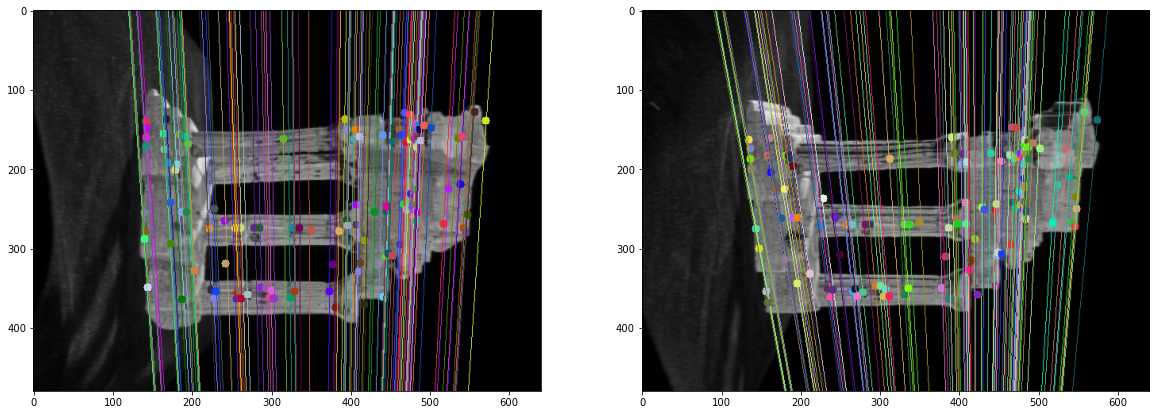

In [9]:
img1 = cv.imread(r'./templeSparseRing/'+im1_fn,0)
img2 = cv.imread(r'./templeSparseRing/'+im2_fn,0) 

sift = cv.SIFT_create()
keypoint_1, descriptor_1 = sift.detectAndCompute(img1,None)
keypoint_2, descriptor_2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptor_1, descriptor_2, k=2)

points_1 = []
points_2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        points_1.append(keypoint_1[m.queryIdx].pt)
        points_2.append(keypoint_2[m.trainIdx].pt)
        

points_1 = np.int32(points_1)
points_2 = np.int32(points_2)
F, mask = cv.findFundamentalMat(points_1, points_2, cv.FM_LMEDS)

points_1 = points_1[mask.ravel()==1]
points_2 = points_2[mask.ravel()==1]

def drawlines(img1,img2,lines,points_1,points_2):
    rows,columns = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    
    for rows,pt1,pt2 in zip(lines,points_1,points_2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -rows[2]/rows[1] ])
        x1,y1 = map(int, [columns, -(rows[2]+rows[0]*columns)/rows[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2



lines_1 = cv.computeCorrespondEpilines(points_2.reshape(-1,1,2), 2,F)
lines_1 = lines_1.reshape(-1,3)
img3,img4 = drawlines(img1,img2,lines_1,points_1,points_2)

lines_2 = cv.computeCorrespondEpilines(points_1.reshape(-1,1,2), 1,F)
lines_2 = lines_2.reshape(-1,3)
img5,img6 = drawlines(img2,img1,lines_2,points_2,points_1)


fig,ax=plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(img5)
ax[1].imshow(img3)

plt.show()
